# Cross-Validation
using cross-validation for better measures of model performance.



## Introduction
Machine learning is an iterative process.

We face choices about what predictive variables to use, what types of models to use, what arguments to supply to those models, etc. So far, I have made these choices in a data-driven way by measuring model quality with a validation (or holdout) set.

But there are some drawbacks to this approach. To see this, imagine you have a dataset with 5000 rows. You will typically keep about 20% of the data as a validation dataset, or 1000 rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of 1000 rows, even if it would be inaccurate on a different 1000 rows.

At an extreme, you could imagine having only 1 row of data in the validation set. If you compare alternative models, which one makes the best predictions on a single data point will be mostly a matter of luck!

In general, the larger the validation set, the less randomness (aka "noise") there is in our measure of model quality, and the more reliable it will be. Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models!

## What is cross-validation?
In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".


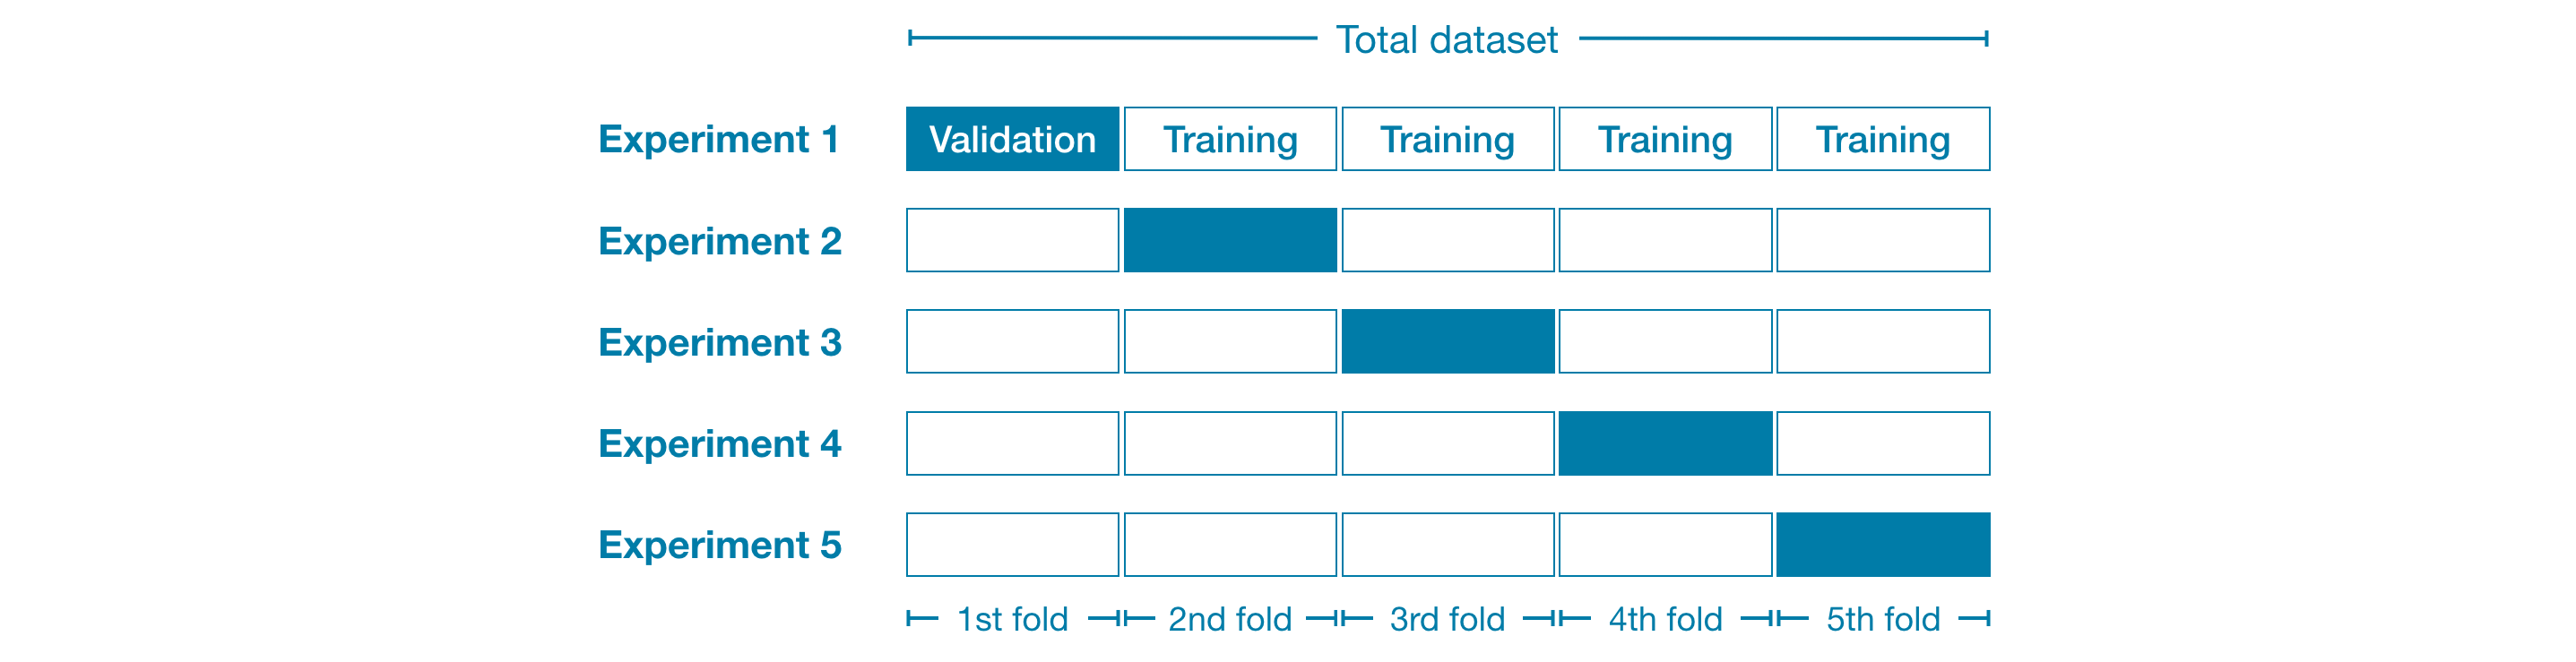

Then, we run one experiment for each fold:

* **In Experiment 1**, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.<br>

* **In Experiment 2**, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
* We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

## When should you use cross-validation?
Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

* For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
* For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.<br>

There's no simple threshold for what constitutes a large vs. small dataset. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('/content/exam_test_scores.csv')
data.columns = data.columns.str.replace(' ', '_')


# Separate target from predictors
cols_to_use = ["writing_score", "reading_score"]
y = data.math_score
X = data[cols_to_use]

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

data.head(5)

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,male,group B,bachelor's degree,standard,none,74,68,67
1,female,group C,some college,standard,completed,58,68,66
2,male,group C,some college,free/reduced,none,66,65,65
3,female,group D,bachelor's degree,free/reduced,none,74,75,73
4,male,group D,some college,standard,none,78,77,71


## Defining Preprocessing



In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Creating a pipeline while Defining the model

Defining a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions.

While it's possible to do cross-validation without pipelines, it is quite difficult! Using a pipeline will make the code remarkably straightforward.

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

We obtain the cross-validation scores with the cross_val_score() function from scikit-learn. We set the number of folds with the cv parameter.

## Cross-Validation

In [24]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [7.60850879 8.02171884 7.9701808  7.60685325 7.92117754]


The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE). The docs for scikit-learn show a list of options.

It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

## Evaluation

In [25]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
7.825687844785395


## Conclusion
Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement!